In [1]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import operator
import json
#from xgboost import XGBClassifier
import re, string
import torch.nn as nn
import torch.nn.functional as F
from fastai import *
from fastai.vision import *
from fastai.tabular import *

from fastai.torch_core import *
from fastai.callback import *
from fastai.callbacks.tracker import *
from fastai.basic_train import LearnerCallback

from pathlib import Path
from sklearn.metrics import precision_recall_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import split_train_set

In [3]:
path = Path("/mnt/sdb/projects/hdfc/DataSet")

train = pd.read_csv(path/"Train_initial.csv", keep_default_na=False)
test = pd.read_csv(path/"Test_initial.csv", keep_default_na=False)
#test_csv = pd.read_csv("dist/Data_Test.csv", keep_default_na=False)
#display(train_csv.head)
#train = preprocess_data(train_csv)
print(train.shape)

(17521, 2358)


In [4]:
columns_text = ""
with open('columns.txt', 'r') as f:
    columns_text = f.readline()

In [5]:
dep_var = 'Col2'
cat_names = train.select_dtypes(include=['object']).columns.tolist()

cont_names = train.select_dtypes(include=[np.number]).columns.tolist()
cont_names.remove('Col2')
#cont_names = columns_text.split(",")
#cont_names.remove('Col1')
#cont_names.remove('Col2')

valid_idx = range(len(train) - int(len(train) * 0.12), len(train))
#valid_df = train[len(train) - int(len(train) * 0.12):]
#print(valid_df.shape)

cat = len(cat_names)
num = len(cont_names)

print('Total Features: ', cat, 'categorical', '+', num, 'numerical', '=', cat+num, 'features')

test_id = test["Col1"]
test = test.drop(columns=['Col1'])

procs = [Normalize]

# Test tabularlist
test = TabularList.from_df(test, cat_names=cat_names, cont_names=cont_names, procs=procs)
#valid_test = TabularList.from_df(final_valid, cat_names=cat_names, cont_names=cont_names, procs=procs)


"""
idx = np.arange(train.shape[0])
train_new, valid, train_idx, valid_idx = train_test_split(train, idx, test_size=0.05, random_state=42)
train_idx.shape, valid_idx.shape
"""

Total Features:  0 categorical + 2357 numerical = 2357 features


'\nidx = np.arange(train.shape[0])\ntrain_new, valid, train_idx, valid_idx = train_test_split(train, idx, test_size=0.05, random_state=42)\ntrain_idx.shape, valid_idx.shape\n'

In [ ]:
# Train data bunch
"""
data = (TabularList.from_df(train, path=path, dep_var, 
                            valid_idx=valid_idx, 
                            cat_names=cat_names, 
                            cont_names=cont_names, 
                            procs=procs)
        .add_test(test)
        .databunch())
"""


data = (TabularList.from_df(train, path=path, cat_names=None, cont_names=cont_names, procs=procs)
        .split_by_idx(valid_idx=valid_idx)
        .label_from_df(cols = dep_var)
        .add_test(test)
        .databunch())

#data = TabularDataBunch.from_df(path, train, dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_names)
#data.add_test(test)

# data = TabularDataBunch.from_df('.', train, dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_names)
#.random_split_by_pct(valid_pct=0.05, seed=43)

In [ ]:
data.show_batch(rows=5)

In [8]:
y_range = [0,1]

learn = tabular_learner(data, layers=[1000, 200, 15], 
                        #ps=[0.001, 0.01], 
                        emb_drop=0.01,
                        #emb_szs={}, 
                        metrics=[error_rate], 
                        # metrics=[r2_score], 
                        callback_fns=ShowGraph)

learn.data.batch_size = 128
learn.loss_func=CrossEntropyFlat()
learn.unfreeze()
learn.layer_groups

[Sequential(
   (0): ModuleList()
   (1): Dropout(p=0.01, inplace=False)
   (2): BatchNorm1d(2357, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (3): Linear(in_features=2357, out_features=1000, bias=True)
   (4): ReLU(inplace=True)
   (5): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): Linear(in_features=1000, out_features=200, bias=True)
   (7): ReLU(inplace=True)
   (8): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (9): Linear(in_features=200, out_features=15, bias=True)
   (10): ReLU(inplace=True)
   (11): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (12): Linear(in_features=15, out_features=2, bias=True)
 )]

In [16]:
#learn.unfreeze(-2)
#learn.freeze()
learn.load('bestmodel')
learn.lr_find()
learn.data = data
learn.unfreeze()

Traceback (most recent call last):
  File "/home/koushik/.conda/envs/image-segmentation/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/koushik/.conda/envs/image-segmentation/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/koushik/.conda/envs/image-segmentation/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/koushik/.conda/envs/image-segmentation/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [76]:
learn.unfreeze()
learn.data.batch_size = 128

In [ ]:
learn.load('bestmodel')

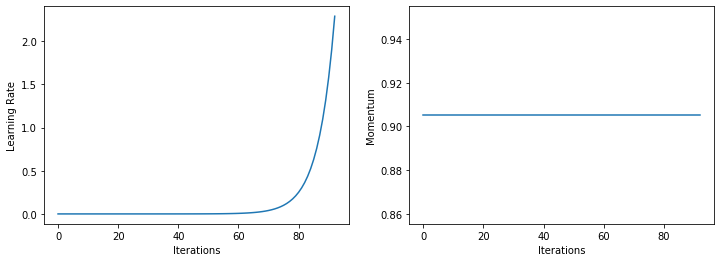

In [17]:
#learn.sched.plot()
learn.recorder.plot_lr(show_moms=True)

Min numerical gradient: 3.98E-06
Min loss divided by 10: 4.37E-06


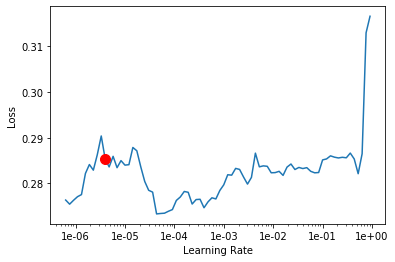

In [18]:
learn.recorder.plot(suggestion = True)
mng3 = learn.recorder.min_grad_lr

epoch,train_loss,valid_loss,error_rate,time
0,0.277115,96.333809,0.102759,00:01
1,0.280024,93.308441,0.102759,00:01
2,0.278140,106.507431,0.104186,00:01
3,0.270408,82.403740,0.102759,00:01
4,0.278508,66.202393,0.103711,00:01
5,0.280212,52.723019,0.102759,00:01
6,0.279982,163.577225,0.105614,00:01
7,0.283774,79.842232,0.102759,00:01
8,0.269943,77.197021,0.102759,00:01
9,0.272043,159.018845,0.103711,00:01


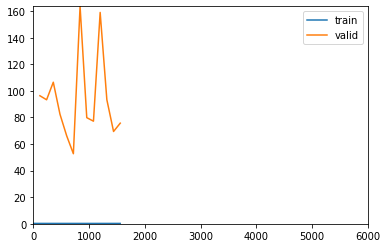

Better model found at epoch 0 with error_rate value: 0.10275927931070328.
Epoch 12: early stopping


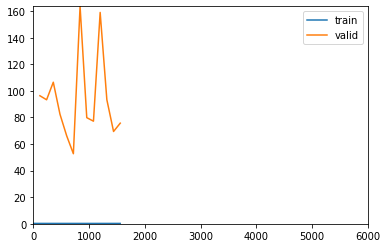

In [19]:
#learn.callback_fns.append(partial(SaveModel, every='epoch'))
#learn.callback_fns.append(partial(EarlyStopping, monitor='accuracy', min_delta=0.01, patience=3))
#learn.fit_one_cycle(80, max_lr=1e-05)
max_lr = slice(mng3)
learn.fit_one_cycle(50, max_lr=max_lr, callbacks=[
    SaveModelCallback(learn, monitor='error_rate',mode='min'),
    EarlyStoppingCallback(learn, monitor='error_rate', min_delta=0.001, patience=5)
])

In [20]:
learn.load('bestmodel')
#learn.TTA(ds_type=DatasetType.Test)
#learn.TTA()
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.01, inplace=False)
  (bn_cont): BatchNorm1d(2357, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=2357, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=1000, out_features=200, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=200, out_features=15, bias=True)
    (7): ReLU(inplace=True)
    (8): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=15, out_features=2, bias=True)
  )
)

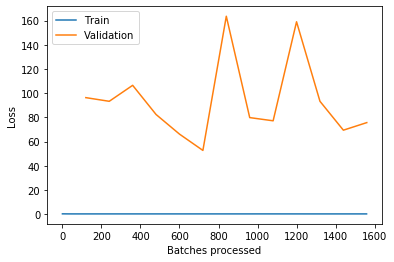

In [21]:
learn.recorder.plot_losses()

In [22]:
[train_preds, train_targets] = learn.get_preds(ds_type=DatasetType.Train)
train_preds = to_np(train_preds)[:, 1]
train_targets = to_np(train_targets)

0.30105304640835706

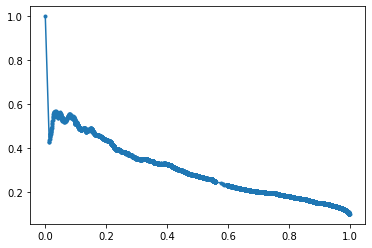

In [23]:
precision, recall, thresholds = precision_recall_curve(train_targets, train_preds)
plt.plot(recall, precision, marker='.')
auprc = auc(recall, precision)
auprc

In [24]:
[valid_preds, valid_targets] = learn.get_preds(ds_type=DatasetType.Valid)
valid_preds = to_np(valid_preds)[:, 1]
valid_targets = to_np(valid_targets)

0.26861951642972937

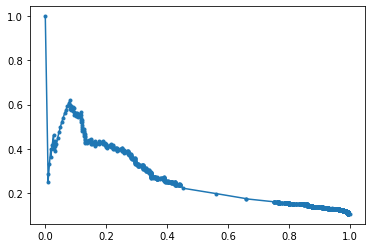

In [98]:
precision, recall, thresholds = precision_recall_curve(valid_targets, valid_preds)
plt.plot(recall, precision, marker='.')
auprc = auc(recall, precision)
auprc

In [86]:
predictions, *_ = learn.get_preds(DatasetType.Test)
#labels = np.argmax(predictions, 1)

In [87]:
labels = np.argmax(predictions, 1)
labels

tensor([0, 0, 0,  ..., 0, 0, 1])

In [88]:
submission = pd.DataFrame({'Col1': test_id, 'Col2': labels})
submission.to_csv('submission_v14.csv', index=False)
submission.head()


,Col1,Col2
0,RIGD58ZWD,0
1,RIH660YDS,0
2,RIH660Q96,0
3,RIYDO15W1,0
4,RIYBGC1ZD,0


In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
